This notebook is used to create summary plots for Figure 4.

* Quantifying variability within cre line and compare to within clusters in cre lines. The goal is to show that clustering data reduces variability
* Size of clusters across cre lines. 



In [2]:
import os
import numpy as np

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

import seaborn as sns

sns.set_context('notebook', font_scale=1, rc={'lines.markeredgewidth': 1})



In [3]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import visual_behavior_glm.GLM_analysis_tools as gat
from visual_behavior.dimensionality_reduction import clustering as vba_clust

In [5]:
import visual_behavior.visualization.utils as utils
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_clustering as glm_clust

palette_experience = utils.get_experience_level_colors()
palette_cre = utils.get_cre_line_colors()

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [7]:

# # load experiments table
experiments_table = loading.get_platform_paper_experiment_table()
# # limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# load matched cells table
cells_table = loading.get_cell_table()
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)


3921 cells in matched cells table


In [34]:
palette = utils.get_cre_line_colors()


### Set up variables and stuff

In [8]:
threshold=0.1

In [9]:
# get GLM output, filter and reshape
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

In [10]:
# set params for saving
folder = '221006_figure4_summary_panels'
file_dir = '220627_shuffle_test/files'

In [11]:
base_dir = r'//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [12]:
# create folder to load and save to
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

#### Load original feature matrix, meta data and cluster labels

In [86]:
filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
all_feature_matrix = pd.read_hdf(os.path.join(base_dir,file_dir, filename), key='df')

In [14]:
filename = 'cluster_metadata_Vip_10_Sst_5_Slc17a7_10.h5'
df_meta = pd.read_hdf(os.path.join(base_dir, file_dir, filename))

In [15]:
filename = 'cluster_labels_Vip_10_Sst_5_Slc17a7_10.h5'
original_cluster_labels = pd.read_hdf(os.path.join(base_dir, file_dir, filename))
original_cluster_labels = original_cluster_labels.reset_index(drop=True)
original_cluster_labels

,labels,cell_specimen_id,cre_line,cluster_id
0,3,1086492406,Vip-IRES-Cre,3
1,2,1086492307,Vip-IRES-Cre,2
2,4,1086492221,Vip-IRES-Cre,4
3,4,1086492174,Vip-IRES-Cre,4
4,2,1086491936,Vip-IRES-Cre,2
...,...,...,...,...
3916,1,1120113340,Slc17a7-IRES2-Cre,10
3917,7,1120112555,Slc17a7-IRES2-Cre,3
3918,2,1120111975,Slc17a7-IRES2-Cre,5
3919,0,1120111711,Slc17a7-IRES2-Cre,1


In [16]:
# trying to fix mismatch of clusters 4 and 5

indices = original_cluster_labels[original_cluster_labels['cre_line']=='Slc17a7-IRES2-Cre'].index.values
original_cluster_labels.loc[indices, 'cluster_id']=original_cluster_labels[original_cluster_labels['cre_line']=='Slc17a7-IRES2-Cre']['cluster_id'].replace([4,5], [5,4])
original_cluster_labels

,labels,cell_specimen_id,cre_line,cluster_id
0,3,1086492406,Vip-IRES-Cre,3
1,2,1086492307,Vip-IRES-Cre,2
2,4,1086492221,Vip-IRES-Cre,4
3,4,1086492174,Vip-IRES-Cre,4
4,2,1086491936,Vip-IRES-Cre,2
...,...,...,...,...
3916,1,1120113340,Slc17a7-IRES2-Cre,10
3917,7,1120112555,Slc17a7-IRES2-Cre,3
3918,2,1120111975,Slc17a7-IRES2-Cre,4
3919,0,1120111711,Slc17a7-IRES2-Cre,1


In [17]:
cre_lines = np.sort(df_meta['cre_line'].unique())
cre_line_dfs = {}
for cre_line in cre_lines:
    cids = df_meta[df_meta['cre_line']==cre_line].index.values
    df_cre = feature_matrix.loc[cids].copy()
    cre_line_dfs[cre_line] = df_cre

#### compute mean dropout scores for original data

In [18]:
cre_mean_dropout_scores = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df)
    
    
    # This is a bandaid fix for clusters 4 and 5 being switched in get_mean_dropout_scores_per_cluster function for some reason, 
    # which makes matching clusters confusing. 
    # if cre_line == 'Slc17a7-IRES2-Cre':
    #     print('changing stuff')
    #     mean_dropout_scores=mean_dropout_scores.rename(columns= {4:5,5:4})
    #     mean_dropout_scores = mean_dropout_scores.reindex(sorted(mean_dropout_scores), axis=1)
    cre_mean_dropout_scores[cre_line] = mean_dropout_scores

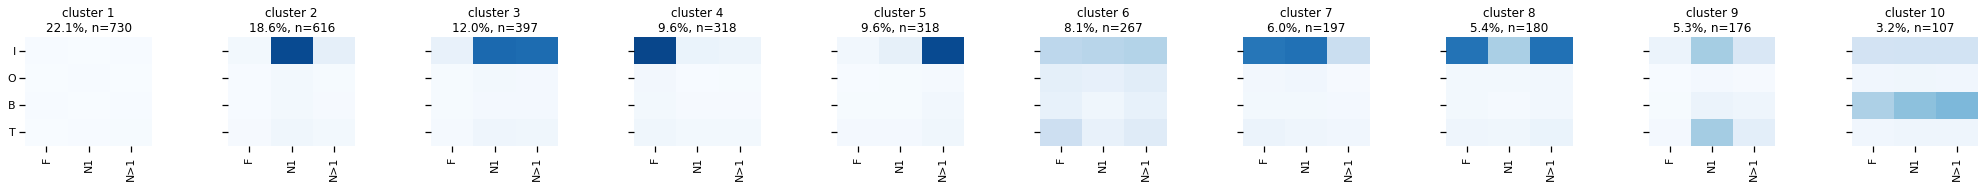

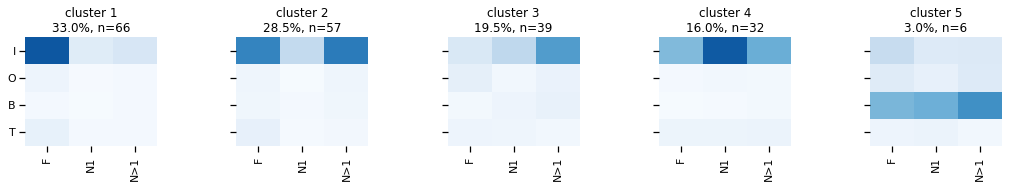

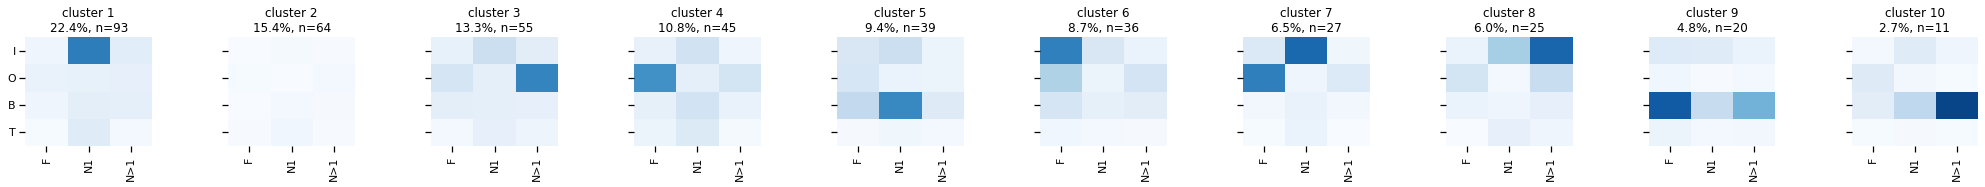

In [19]:
# plot original clusters
sort_order = {}
for cre_line in cre_lines:
    feature_matrix = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line].set_index('cell_specimen_id')
    sort_order[cre_line] = vba_clust.get_sorted_cluster_ids(cluster_df)
    vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
                               sort_order=sort_order, save_dir=save_dir, folder='', suffix='_original',
                                )


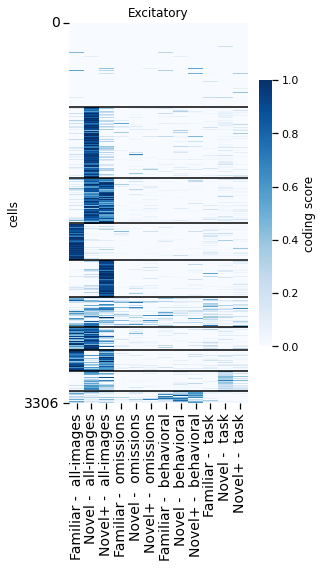

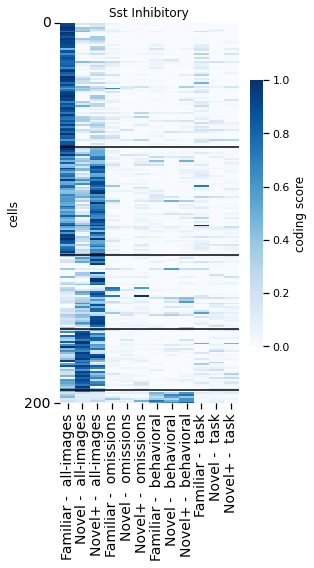

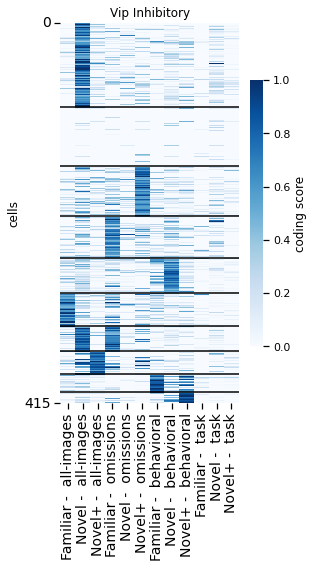

In [67]:
sort_order = {}
for cre_line in cre_lines:
    feature_matrix = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]
    sort_order[cre_line] = vba_clust.get_sorted_cluster_ids(cluster_df)
    vba_clust.plot_unraveled_clusters(feature_matrix, cluster_df, sort_order=sort_order, cre_line=cre_line, save_dir=None, folder='', tag='',
                            ax=None, figsize=(4, 7), rename_columns=True)

#### Plot unraveled means by cre line

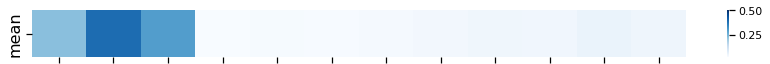

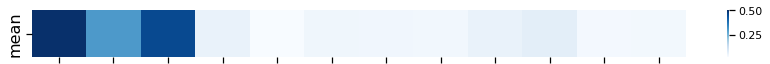

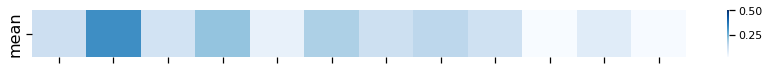

In [83]:
for cre_line in cre_lines:
    feature_matrix = cre_line_dfs[cre_line]
    data_means = feature_matrix.mean().unstack().loc[['all-images', 'omissions', 'behavioral', 'task']].stack().values
    data_means = np.reshape(data_means, (1,12))
    fig, ax = plt.subplots(1,1,figsize = (12, 1))
    ax = sns.heatmap(data_means, cmap='Blues', vmax=.5, ax=ax)
    ax.set_xticklabels('')
    ax.set_yticklabels(['mean'], fontsize=16)
    plt.tight_layout()
    utils.save_figure(fig, figsize=(12,1), save_dir=save_dir, folder='', 
                      fig_title=f'{cre_line}_mean_unraveled_dropout_scores')

### Plot cluster heatmaps with SSE matrix together

In [20]:
#create unstacked mean dropout scores for each cluster for plotting
cre_original_clusters_unstacked = {}
for cre_line in cre_lines:
    dropout_scores = cre_line_dfs[cre_line]
    cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line]

    mean_dropout_scores = vba_clust.get_mean_dropout_scores_per_cluster(dropout_scores, 
                                                  cluster_df = cluster_df, stacked=False)
  
    cre_original_clusters_unstacked[cre_line] = mean_dropout_scores
            

<AxesSubplot:xlabel='experience_level'>

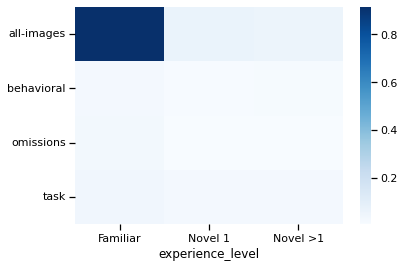

In [21]:
# plot cluster 4 to make sure its correct ('familiar')
sns.heatmap(cre_original_clusters_unstacked[cre_lines[0]][4], cmap='Blues')

### Compute variance

In [87]:
def compute_sse(feature_matrix):
    '''
    Computes Sum of Squared Error between each cell in feature matrix and the mean.
    
    INPUT: 
    feature_matrix (pd.DataFrame) dropout scores, rows are cell specimen ids
    
    Returns:
    SSE (list) of sse values between each cell and their mean.
    '''
    
    N = feature_matrix.shape[0]
    
    mean_values = feature_matrix.mean().values
    
    # SSE = []
    # for i in range(N):
    #     y = feature_matrix.iloc[i].values
    #     SSE.append(np.sum(np.subtract(mean_values,y)**2))
    
    SSE = np.sum(np.subtract(feature_matrix.values, mean_values)**2, axis=1)

    return SSE
    
    

In [88]:
def get_sse_df(feature_matrix, cluster_df, columns = ['cluster_id', 'cre_line'], metric = 'sse'):
    '''
    INPUT:
    feature_matrix:
    cluster_df: (pd.DataFrame) dataframe with columns ['cre_line', 'cluster_id'] and cell specimen id as an index
    metric: (string) 
    
    Returns:
    variability_df
    '''
    
    variability_df = pd.DataFrame(columns=columns)
    cre_lines = vba_clust.get_cre_lines(cluster_df)
    
    columns = [*columns, metric]
    
    if 'cell_specimen_id' in cluster_df.keys():
        cluster_df.set_index('cell_specimen_id', inplace=True)
        
    for cre_line in cre_lines:
        print(cre_line)
        cre_cluster_df = cluster_df[cluster_df.cre_line==cre_line]
        cre_cell_ids = cre_cluster_df.index.values
        cre_feature_matrix = feature_matrix.loc[cre_cell_ids]
        
        cluster_ids = np.sort(cre_cluster_df['cluster_id'].values)
        # compute values for each cluster id
        for cluster_id in cluster_ids:
            cluster_cids = cre_cluster_df[cre_cluster_df.cluster_id==cluster_id].index.values
            cluster_feature_matrix = cre_feature_matrix.loc[cluster_cids]
            if metric is 'sse':
                values = compute_sse(cluster_feature_matrix)
                
                
            variability_df = variability_df.append(pd.DataFrame({'cre_line': [cre_line]*len(values), 
                                   'cluster_id': [cluster_id]*len(values),
                                   metric: values}, index = np.arange(len(values))),
                                                   ignore_index = True)
                                   
            
            
        # compute mean for clustered data
        index = len(variability_df)
        variability_df.at[index,'cre_line'] = cre_line
        variability_df.at[index,'cluster_id'] = 'clustered_mean'
        variability_df.at[index,metric] = variability_df[variability_df.cre_line==cre_line][metric].mean()
        
        # compute mean for unclustered data
        if metric is 'sse':
            value = np.mean(compute_sse(cre_feature_matrix))
        index = len(variability_df)
        variability_df.at[index,'cre_line'] = cre_line
        variability_df.at[index,'cluster_id'] = 'unclustered_mean'
        variability_df.at[index,metric] = value
                
        
    return variability_df
        
            
                
            
        

In [89]:
variability_df = get_sse_df(all_feature_matrix, original_cluster_labels, columns = ['cluster_id', 'cre_line'], metric = 'sse')

Vip-IRES-Cre
Sst-IRES-Cre
Slc17a7-IRES2-Cre


<AxesSubplot:xlabel='cluster_id', ylabel='sse'>

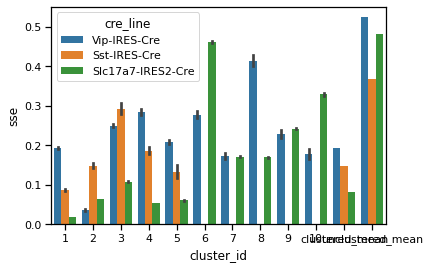

In [90]:
sns.barplot(data = variability_df, x = 'cluster_id', y='sse', hue='cre_line')

In [91]:
def get_sse_df_version2(feature_matrix, cluster_df, columns = ['cluster_id', 'cre_line', 'clustered'], metric = 'sse'):
    '''
    INPUT:
    feature_matrix:
    cluster_df: (pd.DataFrame) dataframe with columns ['cre_line', 'cluster_id'] and cell specimen id as an index
    metric: (string) 
    
    Returns:
    variability_df
    '''
    
    variability_df = pd.DataFrame(columns=columns)
    cre_lines = np.sort(vba_clust.get_cre_lines(cluster_df))
    
    columns = [*columns, metric]
    
    if 'cell_specimen_id' in cluster_df.keys():
        cluster_df.set_index('cell_specimen_id', inplace=True)
        
    for cre_line in cre_lines:
        print(cre_line)
        cre_cluster_df = cluster_df[cluster_df.cre_line==cre_line]
        cre_cell_ids = cre_cluster_df.index.values
        cre_feature_matrix = feature_matrix.loc[cre_cell_ids]
        
        cluster_ids = np.sort(cre_cluster_df['cluster_id'].values)
        # compute values for each cluster id
        for cluster_id in cluster_ids:
            cluster_cids = cre_cluster_df[cre_cluster_df.cluster_id==cluster_id].index.values
            cluster_feature_matrix = cre_feature_matrix.loc[cluster_cids]
            if metric is 'sse':
                values = compute_sse(cluster_feature_matrix)
                
                
            variability_df = variability_df.append(pd.DataFrame({'cre_line': [cre_line]*len(values), 
                                   'cluster_id': [cluster_id]*len(values),
                                    'clustered': [True]*len(values),
                                   metric: values}, index = np.arange(len(values))),
                                                   ignore_index = True)
                                   
            
        if metric is 'sse':
            values = compute_sse(cre_feature_matrix)
        variability_df = variability_df.append(pd.DataFrame({'cre_line': [cre_line]*len(values), 
                                   'cluster_id': [np.nan]*len(values),
                                    'clustered': [False]*len(values),
                                   metric: values}, index = np.arange(len(values))),
                                                   ignore_index = True)
                
        
    return variability_df
        
            
   

In [93]:
variability_df2 = get_sse_df_version2(all_feature_matrix, original_cluster_labels, columns = ['cluster_id', 'cre_line'], metric = 'sse')

Slc17a7-IRES2-Cre
Sst-IRES-Cre
Vip-IRES-Cre


<AxesSubplot:xlabel='clustered', ylabel='sse'>

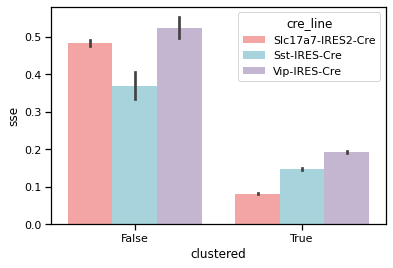

In [94]:
sns.barplot(data = variability_df2, x = 'clustered', y = 'sse', hue = 'cre_line', palette=palette)

<AxesSubplot:xlabel='clustered', ylabel='sse'>

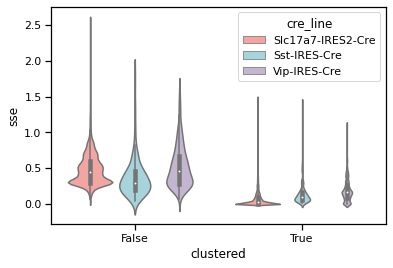

In [95]:
palette = utils.get_cre_line_colors()
sns.violinplot(data = variability_df2, x = 'clustered', y = 'sse', hue = 'cre_line', palette=palette)

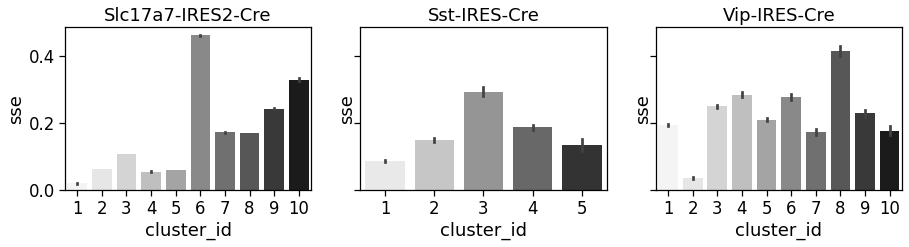

In [210]:
fig, ax = plt.subplots(1,3, figsize = (15,3), sharey=True)
for i,cre_line in enumerate(cre_lines):
    tmp = variability_df2[variability_df2.cre_line==cre_line]
    sns.barplot(data = tmp[tmp.clustered==True], x = 'cluster_id', y = 'sse', palette='Greys',ax=ax[i])
    ax[i].set_title(cre_line)

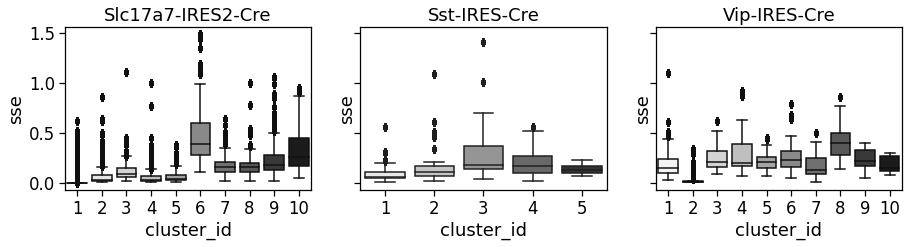

In [211]:
fig, ax = plt.subplots(1,3, figsize = (15,3), sharey = True)
for i,cre_line in enumerate(cre_lines):
    tmp = variability_df2[variability_df2.cre_line==cre_line]
    sns.boxplot(data = tmp[tmp.clustered==True], x = 'cluster_id', y = 'sse', palette='Greys',ax=ax[i])
    ax[i].set_title(cre_line)

### Point plot to show variability

In [96]:
from matplotlib.lines import Line2D
from scipy import stats 


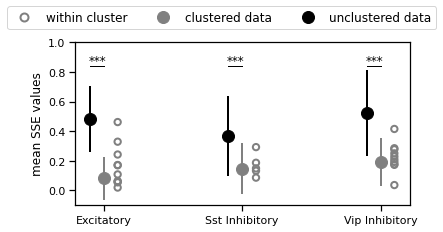

In [97]:

fig, ax = plt.subplots(1,1, figsize = (6,3))
x1 = [0.9, 1.9, 2.9,] # not clustered x location
x2 = [1.1, 2.1, 3.1] # clustered x location
xticklabels = utils.get_cell_types()
labels = [Line2D([0],[0], marker='o', markersize = 8, markerfacecolor='none', markeredgecolor='Grey', markeredgewidth=2, linewidth=0),
        Line2D([0],[0], marker='o', markersize = 12, color='Grey', linewidth=0 ),
         Line2D([0],[0], marker='o', markersize=12, color='Black', linewidth=0)]
for c, cre_line in enumerate(cre_lines):
    cre_tmp = variability_df2[(variability_df2.cre_line==cre_line)]
    # plot clusters means
    cluster_tmp = cre_tmp[cre_tmp.clustered==True]
    y = cluster_tmp.groupby('cluster_id').mean().values
    x = [x2[c]]*len(y)
    ax.scatter(x=x,y=y,marker = 'o', s=40, facecolors='none', edgecolors='Grey',linewidth=2)
    
    # plot clustered mean
    x = x2[c]
    y = cluster_tmp['sse'].mean()
    err = cluster_tmp['sse'].std()
    ax.errorbar(x=x-0.1,y=y,yerr=err, marker='o', markersize = 12, color='Grey', linewidth=2)

    # plot not clustered mean
    x=x1[c]
    y = cre_tmp[(cre_tmp.clustered==False)]['sse'].mean()
    err = cre_tmp[(cre_tmp.clustered==False)]['sse'].std()
    ax.errorbar(x=x,y=y,yerr=err, marker='o', markersize=12, color='Black', linewidth=2)
    
    # add significance stars
    ax.text(x1[c]-0.01, 0.85, s='***', fontsize=12, color='Black')
    ax.plot([x1[c], x2[c]-0.1], [0.84, 0.84], color='Black', linewidth=1)
ax.set_xticks([1,2,3])
ax.set_xticklabels(xticklabels)
ax.set_ylabel('mean SSE values')
ax.set_ylim([-0.1, 1])

ax.legend(labels, ['within cluster', 'clustered data', 'unclustered data'],
          loc="center right", 
    ncol=3,
    bbox_to_anchor=[1.08, 1.15],
    borderaxespad=0, fontsize = 12)

utils.save_figure(fig, figsize = (6,3), save_dir=save_dir, folder='', fig_title = 'Reduction_in_variability')

#### Compare cre line variance only


In [101]:
tmp = variability_df2[(variability_df2.clustered==False)]

In [103]:
SSE = []
for c, cre_line in enumerate(cre_lines):
    SSE.append(tmp[tmp.cre_line==cre_line]['sse'].values)

#### Statistics

In [108]:
from scipy.stats import ranksums
from scipy.stats import f_oneway

In [113]:
print('one way anova to test cre line variability')
f_oneway(SSE[0], SSE[1], SSE[2])

one way anova to test cre line variabilit


F_onewayResult(statistic=30.940006445407494, pvalue=4.655140610190392e-14)

In [112]:
print('Slc and SST: ', ranksums(SSE[0], SSE[1]))
print('SST and VIP: ', ranksums(SSE[1], SSE[2]))
print('Slc and VIP: ', ranksums(SSE[0], SSE[2]))

Slc and SST:  RanksumsResult(statistic=9.342903823186978, pvalue=9.372758245846677e-21)
SST and VIP:  RanksumsResult(statistic=-7.4011515880074565, pvalue=1.3500850403417842e-13)
Slc and VIP:  RanksumsResult(statistic=-0.4097678061854845, pvalue=0.6819762845175716)


#### Plot cre line differences

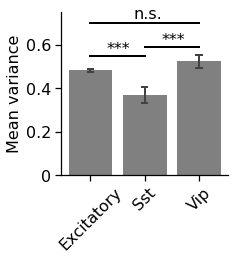

In [186]:
fig, ax = plt.subplots(1,1, figsize = (3,3))
tmp = variability_df2[(variability_df2.clustered==False)]
# ax = sns.pointplot(data=tmp, x = 'cre_line', 
#               y='sse', join=False, color='Black', 
#                    scale=1.8, errwidth=2,capsize=0.1,
#                    ax=ax)
ax = sns.barplot(data=tmp, x = 'cre_line', 
              y='sse',  color='Grey', 
                    errwidth=2,capsize=0.1,
                   ax=ax)
ax.set_xticklabels(['Excitatory', 'Sst', 'Vip'], rotation=45, fontsize=16)
ax.set_xlabel('')
ax.set_ylim([0,0.75])
yticks = [0, 0.2, 0.4, 0.6]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=16)
ax.set_ylabel('Mean variance', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# add significance stars
ax.text(0.3, 0.56, s='***', fontsize=16, color='Black')
ax.plot([0, 1], [0.55, 0.55], color='Black', linewidth=2)

ax.text(1.3, 0.6, s='***', fontsize=16, color='Black')
ax.plot([1, 2], [0.59, 0.59], color='Black', linewidth=2)

ax.text(0.8, 0.72, s='n.s.', fontsize=16, color='Black')
ax.plot([0, 2], [0.7, 0.7], color='Black', linewidth=2)
utils.save_figure(fig, figsize = (3,3), save_dir=save_dir, folder='', fig_title = 'Mean_variability_by_cell_type')

#### post clustering statistics

In [187]:
for c, cre_line in enumerate(cre_lines):
    cre_tmp = variability_df2[(variability_df2.cre_line==cre_line)]
    print(ranksums(cre_tmp[cre_tmp.clustered==True]['sse'].values, cre_tmp[cre_tmp.clustered==False]['sse'].values))

RanksumsResult(statistic=-91.13665731161788, pvalue=0.0)
RanksumsResult(statistic=-16.71859818950396, pvalue=9.594968146534638e-63)
RanksumsResult(statistic=-26.39031260726713, pvalue=1.7700368872284653e-153)


### Cluster size plots

In [188]:
for c, cre_line in enumerate(cre_lines):
    cre_tmp = original_cluster_labels[(original_cluster_labels.cre_line==cre_line)]

In [189]:
normalized_values = original_cluster_labels.groupby('cre_line')['cluster_id'].value_counts(normalize=True).values

In [190]:
grouped_df = original_cluster_labels.groupby(['cre_line','cluster_id']).count().reset_index()

In [191]:
grouped_df['normalized'] = normalized_values
grouped_df['percentage'] = grouped_df['normalized'] *100

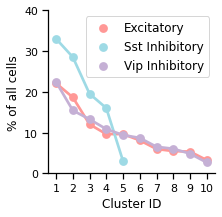

In [195]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
markersize = [14, 10, 10]
linewidth = [4, 2, 2]
ax=sns.pointplot(data = grouped_df, x = 'cluster_id', y = 'percentage',
              hue= 'cre_line', palette = palette,joinlinewidth=0.1,ax=ax)
ax.legend(ax.get_legend_handles_labels()[0],utils.get_cell_types(), fontsize=12)
ax.set_ylim([0,40])
ax.set_xlabel('Cluster ID')
ax.set_ylabel('% of all cells')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
utils.save_figure(fig, figsize = (3,3), save_dir=save_dir, folder='', fig_title = 'Cluster_sizes_cre')

In [32]:
labels_cre = {}
for cre_line in cre_lines:
    labels_cre[cre_line] = original_cluster_labels[original_cluster_labels.cre_line==cre_line]['cluster_id'].values

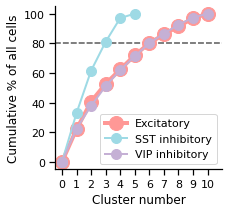

In [198]:
fig, ax = plt.subplots(1,1, figsize = (3,3))
ax = vba_clust.plot_N_clusters_by_cre_line(labels_cre, ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
utils.save_figure(fig, figsize = (3,3), save_dir=save_dir, folder='', fig_title = 'Cumulative_cluster_sizes_cre')

#### Pie chart plots

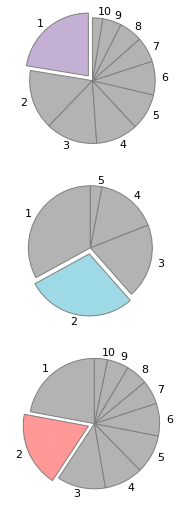

In [35]:
explode_index = [0,1,1]

fig, ax = plt.subplots(3,1, figsize = (3, 9))
for c, cre_line in enumerate(cre_lines[::-1]):
    cluster_ids = grouped_df[grouped_df.cre_line==cre_line]['cluster_id'].values
    cluster_id_labels = [str(cluster_id) for cluster_id in cluster_ids]
    sizes = grouped_df[grouped_df.cre_line==cre_line]['percentage'].values
    explode = [0]*len(cluster_ids)
    explode[explode_index[c]] = 0.1
    colors = [(0.7, 0.7, 0.7)]*len(cluster_ids)
    colors[explode_index[c]] = palette[::-1][c]
    pie = ax[c].pie(sizes, explode=explode, labels=cluster_id_labels, colors = colors,startangle=90)
    for w in pie[0]:
        w.set_linewidth(1)
        w.set_edgecolor('Grey')

    ax[c].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
utils.save_figure(fig, figsize = (3, 9), save_dir=save_dir, folder='', fig_title = 'pie_chart_cluster_size')

## Mean image responses for disinhibitory circuit example

### Optimal k

In [219]:
from sklearn.cluster import SpectralClustering
import pickle 

In [227]:
n_clusters_cre = {'Slc17a7-IRES2-Cre': 10,
                 'Sst-IRES-Cre': 5, 
                 'Vip-IRES-Cre':10}

In [220]:
distance_metrics = ['euclidean']
shuffle_type = 'all'

for metric in distance_metrics:
    gap_filename = os.path.join(save_dir, 'gap_scores_{}_{}_nb20_{}.pkl'.format(metric, glm_version, shuffle_type))
    if os.path.exists(gap_filename):
        with open(gap_filename, 'rb') as f:
            gap_df = pickle.load(f)
            f.close()
        print('file exists...')
    else:
        gap_df = {}
        for i, cre_line in enumerate(cre_lines):
            df = cre_line_dfs[cre_line]
            sc = SpectralClustering()
            gap_statistics = vba_clust.compute_gap(sc, df, k_max = 25, reference_shuffle='all', metric=metric)
            gap_df[cre_line]= gap_statistics
        
        vba_clust.save_clustering_results(gap_df, gap_filename)

file exists...


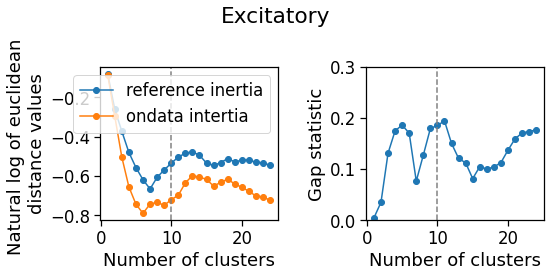

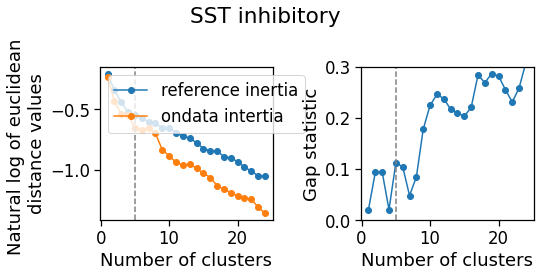

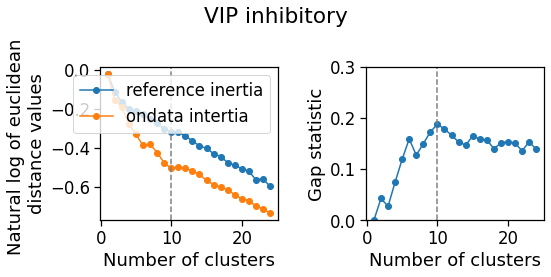

In [229]:
vba_clust.plot_gap_statistic(gap_statistic=gap_df, cre_lines=cre_lines, n_clusters_cre=n_clusters_cre,
                   tag='10_5_10', save_dir=save_dir, folder='gap_statistic')

### Plot coclustering matrix

In [238]:
filename = os.path.join(save_dir, '24_events_all_L2_optimize_by_session_coClustering_matrix.pkl')
if os.path.exists(filename):
    print('loading file...')
    with open(filename, 'rb') as f:
        coclustering_matrices  = pkl.load(f)
        f.close()
        print('done.')
else:
    coclustering_matrices = {}
    for i, cre_line in enumerate(cre_lines):
        cids = df_meta[df_meta['cre_line']==cre_line]['cell_specimen_id']
        X = cre_line_dfs[cre_line].values
        m = vba_clust.get_coClust_matrix(X,n_clusters=n_clusters_cre[cre_line], nboot=np.arange(100))
        coclustering_matrices[cre_line]=m
    vba_clust.save_clustering_results(coclustering_matrices, filename)
    

loading file...
done.


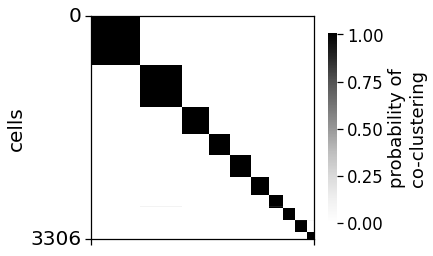

In [249]:

for cre_line in [cre_lines[0]]:
    vba_clust.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_matrices, original_cluster_labels,
                                                              cre_line, save_dir, folder='')

In [250]:
data_type = 'filtered_events'

interpolate = True
output_sampling_rate = 30

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
inclusion_criteria = 'platform_experiment_table'

# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'omitted']

# suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

all_images_mdf = multi_session_df[multi_session_df.omitted==False]

there are 1249 experiments in the full multi_session_df
getting experiment table for March and August releases from lims
excluding Ai94 data
there are 402 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


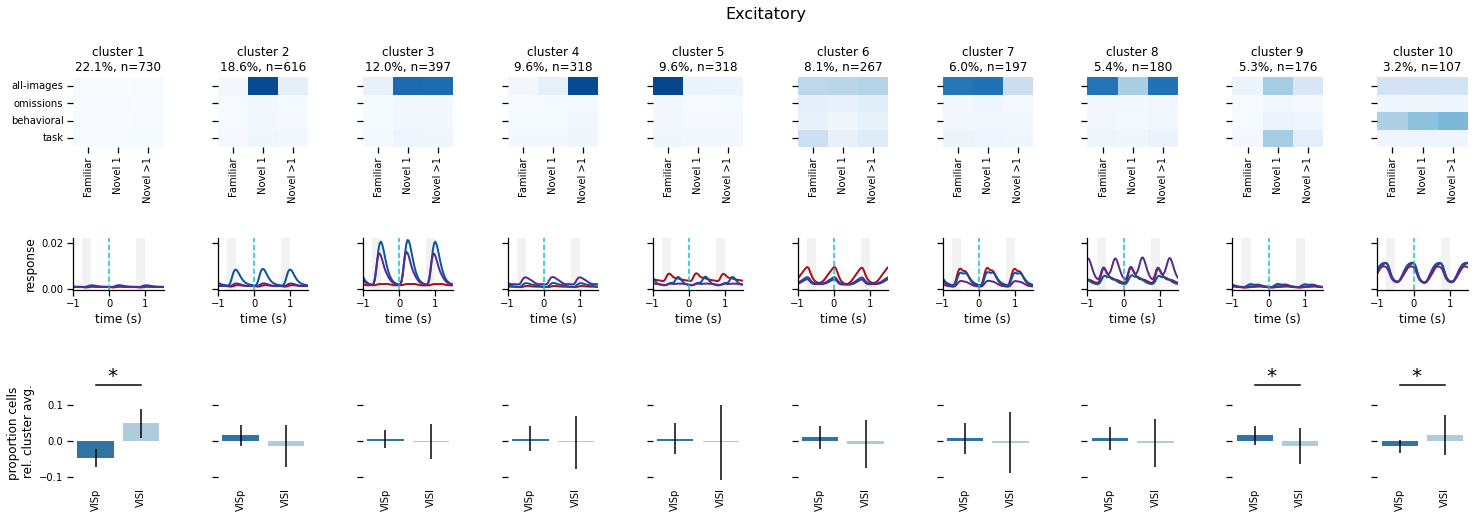

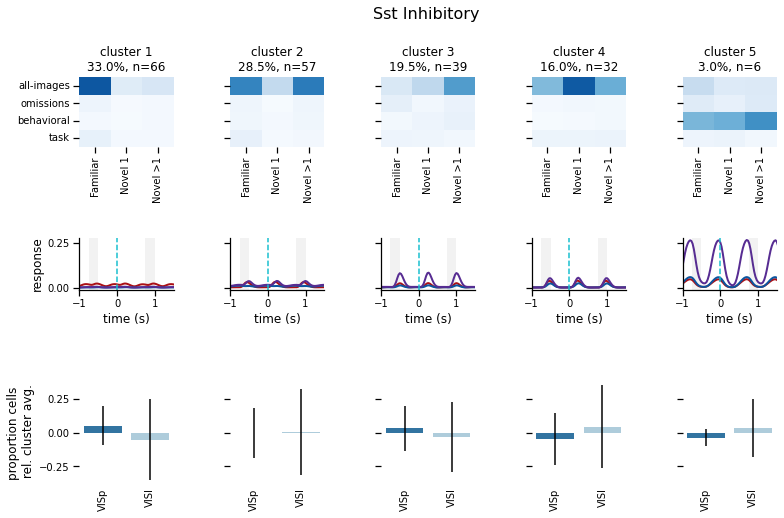

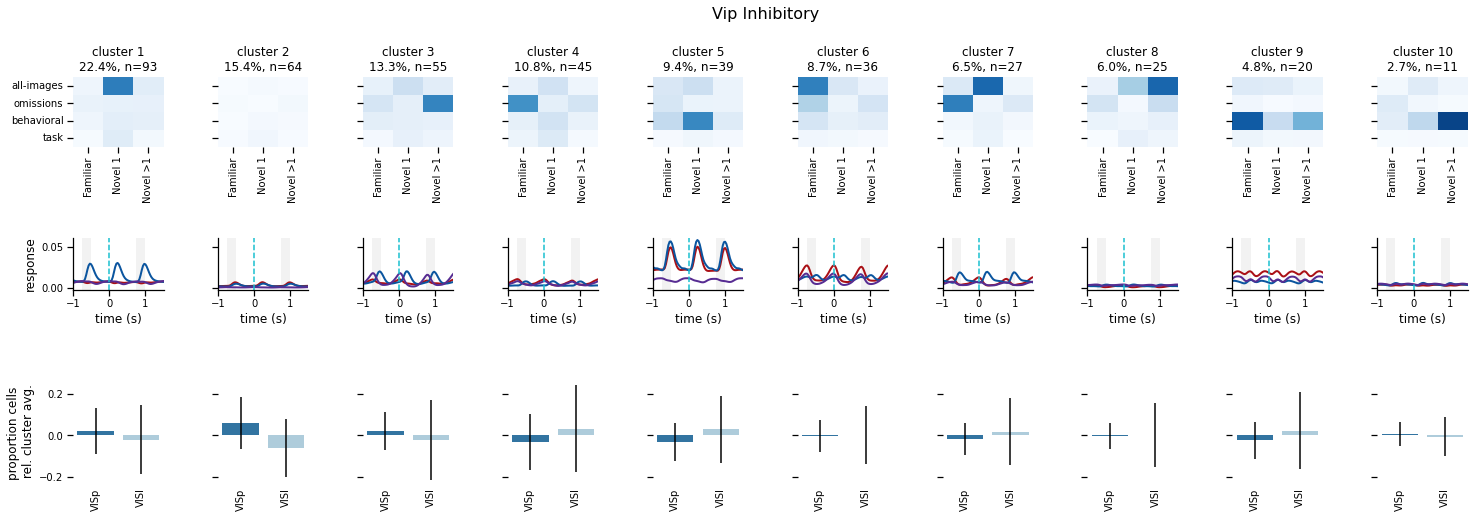

In [252]:
# this plot doesnt work without multi_session_df
folder = 'targeted_structure'
for cre_line in cre_lines:
    vba_clust.plot_clusters_stats_pop_avg_rows(df_meta, cre_line_dfs[cre_line], multi_session_df=all_images_mdf, cre_line = cre_line,
                                     columns_to_groupby=[folder], change=False, omitted=True,
                                     sort_order=None, save_dir=save_dir, folder=folder, suffix='', alpha=0.05)


In [255]:
cids = df_meta[(df_meta.cre_line==cre_line) & (df_meta.cluster_id==cluster_id_sel[c])].index.values

cell_specimen_id
1086492406    3
1086492307    2
1086492221    4
1086492174    4
1086491936    2
             ..
1086631288    1
1086631205    8
1086631138    1
1086631077    2
1086630543    5
Name: cluster_id, Length: 415, dtype: int64

### Plot mean traces for example disinhibitory circuit

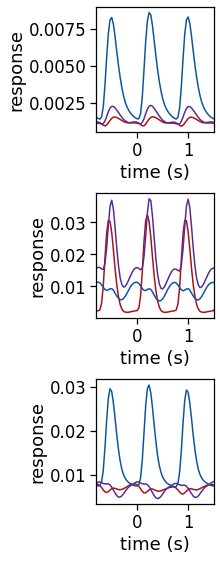

In [291]:
cluster_ids_sel = [2,2,1]
fig, ax = plt.subplots(3,1, figsize=(3,9))
colors = utils.get_experience_level_colors()
for c, cre_line in enumerate(cre_lines):
    ts = all_images_mdf.trace_timestamps.iloc[0]
    cids = df_meta[(df_meta.cre_line==cre_line) & (df_meta.cluster_id==cluster_ids_sel[c])].index.values
    sel_df = all_images_mdf[all_images_mdf.cell_specimen_id.isin(cids)][['mean_trace', 'experience_level']]
    experience_levels = np.sort(sel_df.experience_level.unique())
    for e,exp in enumerate(experience_levels):
        exp_df = sel_df[sel_df.experience_level==exp]
        ax[c].plot(ts,exp_df.mean_trace.mean(), color=colors[e])
    ax[c].set_xlim([-0.8,1.5])
    ax[c].set_xlabel('time (s)')
    ax[c].set_ylabel('response')
plt.tight_layout()
utils.save_figure(fig, save_dir=save_dir, folder='', figsize=(4,8), fig_title='mean_responses_disinhibitory_circuit')
    

In [259]:
sel_df  = all_images_mdf[['mean_trace', 'experience_level']]

,mean_trace,experience_level
2538,"[0.00026097883620400944, 0.0002568036432591395...",Familiar
2540,"[0.0015787272721766484, 0.0017454733290374867,...",Familiar
2542,"[0.000748106131175682, 0.0007469053058682863, ...",Familiar
2544,"[0.0030282107565481366, 0.003237947818870927, ...",Familiar
2546,"[0.00045998280642151816, 0.0004533011520074236...",Familiar
...,...,...
155794,"[4.491027966999342e-05, 3.204402311743882e-05,...",Novel >1
155796,"[0.00018783784406378704, 0.0001517493425407559...",Novel >1
155798,"[0.0002914402994164741, 0.00023059844505826644...",Novel >1
155800,"[9.813933584149975e-06, 5.674806165247624e-06,...",Novel >1


(-1.0, 1.0)

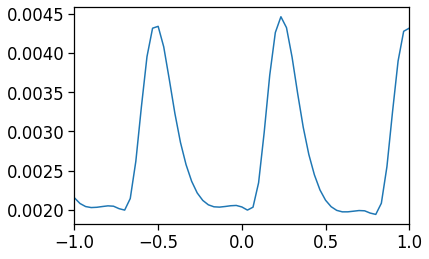

In [270]:
fig, ax = plt.subplots(1,1)


array([-2.        , -1.96666667, -1.93333333, -1.9       , -1.86666667,
       -1.83333333, -1.8       , -1.76666667, -1.73333333, -1.7       ,
       -1.66666667, -1.63333333, -1.6       , -1.56666667, -1.53333333,
       -1.5       , -1.46666667, -1.43333333, -1.4       , -1.36666667,
       -1.33333333, -1.3       , -1.26666667, -1.23333333, -1.2       ,
       -1.16666667, -1.13333333, -1.1       , -1.06666667, -1.03333333,
       -1.        , -0.96666667, -0.93333333, -0.9       , -0.86666667,
       -0.83333333, -0.8       , -0.76666667, -0.73333333, -0.7       ,
       -0.66666667, -0.63333333, -0.6       , -0.56666667, -0.53333333,
       -0.5       , -0.46666667, -0.43333333, -0.4       , -0.36666667,
       -0.33333333, -0.3       , -0.26666667, -0.23333333, -0.2       ,
       -0.16666667, -0.13333333, -0.1       , -0.06666667, -0.03333333,
        0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
        0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3 

In [265]:
ts = all_images_mdf.trace_timestamps.iloc[0]